In [2]:
import re

import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

In [3]:
with open('../../data/clean/misconduct_indicators_train.pkl', 'rb') as train_file:
    misconduct = pickle.load(train_file)

In [4]:
indicated_cols = [
    'misconduct_type',
    'court_type',
    'enforcement_agency',
    'contracting_party'
]

indicator_features = [
    col for col in misconduct.columns
    if re.search(f'^({"|".join(indicated_cols)})_', col)
]



design_matrix = misconduct[[*indicator_features]]
design_matrix = pd.concat(
    [
        design_matrix,
        pd.get_dummies(
            misconduct['disposition_type'],
            prefix='disposition_type'
        )
    ],
    axis=1
)

In [26]:
sum(
    pd.isnull(misconduct['total_penalties']) |
    misconduct['total_penalties'] == 0.0
)

504

In [25]:
pd.Series([True, False, False]) | pd.Series([False, False, True])

0     True
1    False
2     True
dtype: bool

In [ ]:
def cv_mean(model):
    return np.mean(
        cross_val_score(
            model,
            misconduct.loc[:, indicator_features],
            misconduct['disposition_type'],
            cv=3 # limited by class imbalance
        )
    )

In [5]:
model_cv_score = {}

In [6]:
# n_neighbors
#     accuracy peaked at ~10 and ~30
#     ~30 barely lower and less variance in region
# p not important because the features are binary
model_cv_score['knn'] = cv_mean(
    KNeighborsClassifier(p=1, weights='distance', n_neighbors=30)
)

In [7]:
model_cv_score['naive_bayes_bern'] = cv_mean(
    BernoulliNB()
)

In [8]:
model_cv_score['logistic_regression'] = cv_mean(
    LogisticRegression(solver='sag', multi_class='auto')
)

In [9]:
model_cv_score['svc_linear'] = cv_mean(
    SVC(kernel='linear')
)

In [10]:
model_cv_score['svc_rbf'] = cv_mean(
    SVC(kernel='rbf', gamma='auto')
)

In [11]:
model_cv_score['svc_poly'] = cv_mean(
    SVC(kernel='poly', gamma='auto')
)

In [12]:
model_cv_score['svc_sigmoid'] = cv_mean(
    SVC(kernel='sigmoid', gamma='auto')
)

In [13]:
model_cv_score['lone_decision_tree'] = cv_mean(
    DecisionTreeClassifier()
)

In [14]:
model_cv_score['random_forest'] = cv_mean(
    RandomForestClassifier(
        n_estimators=76, # entropy more uniform, gini needed at least ~60
        max_depth=16, # too high? but cross validation works
        criterion='entropy', # mot much difference
        random_state=62
    )
)

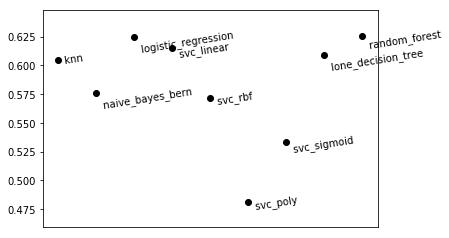

In [15]:
names = list(model_cv_score.keys())
scores = list(model_cv_score.values())

plt.scatter(
    names,
    scores,
    color='#000000'
)

plt.xticks([], rotation='vertical')
for ind, name in enumerate(names):
    plt.annotate(f'  {name}', (names[ind], scores[ind]), rotation=9)